# COGS 118B - Final Project

# Insert title here

## Group members

- Pelé
- Diego Maradonna
- Johan Cruyff
- Roberto Carlos
- Franz Beckenbaur

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

Fill in the background and discuss the kind of prior work that has gone on in this research area here. **Use inline citation** to specify which references support which statements.  You can do that through HTML footnotes (demonstrated here). I used to reccommend Markdown footnotes (google is your friend) because they are simpler but recently I have had some problems with them working for me whereas HTML ones always work so far. So use the method that works for you, but do use inline citations.

Here is an example of inline citation. After government genocide in the 20th century, real birds were replaced with surveillance drones designed to look just like birds<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote). Use a minimum of 2 or 3 citations, but we prefer more <a name="admonish"></a>[<sup>[2]</sup>](#admonishnote). You need enough citations to fully explain and back up important facts. 

Remeber you are trying to explain why someone would want to answer your question or why your hypothesis is in the form that you've stated. 

# Problem Statement

Clearly describe the problem that you are solving. Avoid ambiguous words. The problem described should be well defined and should have at least one ML-relevant potential solution. Additionally, describe the problem thoroughly such that it is clear that the problem is quantifiable (the problem can be expressed in mathematical or logical terms), measurable (the problem can be measured by some metric and clearly observed), and replicable (the problem can be reproduced and occurs more than once).

# Data

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


In [2]:
import pandas as pd


file_path = 'raw_data.csv'
data = pd.read_csv(file_path)


data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Columns: 294 entries, RegionID to 2024-01-31
dtypes: float64(289), int64(2), object(3)
memory usage: 2.0+ MB


(   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31  \
 0    102001         0    United States    country       NaN  118650.519637   
 1    394913         1     New York, NY        msa        NY  213396.000613   
 2    753899         2  Los Angeles, CA        msa        CA  220076.895374   
 3    394463         3      Chicago, IL        msa        IL  148207.471745   
 4    394514         4       Dallas, TX        msa        TX  124266.465332   
 
       2000-02-29     2000-03-31     2000-04-30     2000-05-31  ...  \
 0  118859.263937  119118.137606  119673.370810  120312.377661  ...   
 1  214302.813213  215218.024533  217072.596808  218993.070624  ...   
 2  220895.860656  221986.714601  224157.147508  226530.920673  ...   
 3  148344.668689  148605.962687  149255.997216  150037.910569  ...   
 4  124321.814050  124385.443067  124550.680941  124768.542554  ...   
 
       2023-04-30     2023-05-31     2023-06-30     2023-07-31     2023-08-31  \
 0  332578.5903

In [3]:
df = data 

price_columns = df.columns[5:]  
df[price_columns] = df[price_columns].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


def month_to_quarter(month):
    return (month - 1) // 3 + 1

quarterly_avgs = {}
for col in price_columns:
    year, month, _ = col.split('-')
    quarter = month_to_quarter(int(month))
    quarter_col = f"{year}-Q{quarter}_avg"
    
    if quarter_col not in quarterly_avgs:
        quarterly_avgs[quarter_col] = []
    quarterly_avgs[quarter_col].append(col)

for quarter_col, cols in quarterly_avgs.items():
    df[quarter_col] = df[cols].mean(axis=1)


df = df[[col for col in df.columns if not col in price_columns]]


In [4]:
df = df.dropna(subset=['RegionName', 'RegionType', 'StateName'], how='any')
df.to_csv('cleaned_without_geo')

In [5]:
unique_region_names = df['RegionName'].nunique()

In [7]:
print(unique_region_names)

894


In [9]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Load your dataset
df = pd.read_csv('cleaned_without_geo.csv')

# Select the first 10 entries for demonstration purposes
df_subset = df.head(10)

# Initialize the geocoder with a user agent, e.g., "myGeocodeApp"
geolocator = Nominatim(user_agent="myGeocodeApp")
# Use the rate limiter to avoid hitting API limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Define a function to geocode a location name
def geocode_location(row):
    try:
        # Geocode the location name
        location = geocode(row['RegionName'])
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])

# Apply the geocoding function to each row
geocoded = df_subset.apply(geocode_location, axis=1)
df_subset[['Latitude', 'Longitude']] = geocoded

# Display the DataFrame with the new Latitude and Longitude columns
print(df_subset[['RegionName', 'Latitude', 'Longitude']])

# Note: This script processes only the first 10 entries for demonstration. Adjust as needed.

         RegionName   Latitude   Longitude
0      New York, NY  40.712728  -74.006015
1   Los Angeles, CA  34.053691 -118.242766
2       Chicago, IL  41.875562  -87.624421
3        Dallas, TX  32.776272  -96.796856
4       Houston, TX  29.758938  -95.367697
5    Washington, DC  38.895037  -77.036543
6  Philadelphia, PA  39.952724  -75.163526
7         Miami, FL  25.774173  -80.193620
8       Atlanta, GA  33.748992  -84.390264
9        Boston, MA  42.355433  -71.060511


/Users/thepunisher/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = pd.read_csv('cleaned_without_geo.csv')


geolocator = Nominatim(user_agent="my_app")


geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)


def geocode_location(row):
    try:
        location = geocode(row['RegionName'])
        if location:
            address = location.raw.get('address', {})
            zip_code = address.get('postcode', None)
            return pd.Series([location.latitude, location.longitude, zip_code])
    except Exception as e:
        print(f"Error geocoding {row['RegionName']}: {e}")
    return pd.Series([None, None, None])


df[['Latitude', 'Longitude', 'ZIP']] = df.apply(geocode_location, axis=1)


df.to_csv('cleaned_with_geo.csv', index=False)


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Worcester, MA',), **{}).
Traceback (most recent call last):
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/http/client.py", line 1371, in getresponse
    response.begin()
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/http/client.py", line 319, in begin
    version, status, reason = self._read_status()
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/http/client.py", line 280, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/thepunisher/opt/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    re

In [14]:
missing_lat_long = df[(df['Latitude'].isna()) | (df['Longitude'].isna())]
missing_zip = df[df['ZIP'].isna()]

# Count the number of entries missing Latitude and Longitude
num_missing_lat_long = missing_lat_long.shape[0]
print(num_missing_lat_long)
# Count the number of entries missing ZIP code
num_missing_zip = missing_zip.shape[0]
print(num_missing_zip)

8
894


In [20]:
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)


In [23]:
df.to_csv('cleaned_with_geo.csv', index=False)

In [32]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:", numerical_cols)

numerical_cols_set = set(numerical_cols)
exclude_cols_set = set(['Latitude', 'Longitude', 'Latitude_rad', 'Longitude_rad', 'RegionID', 'SizeRank'])


cols_to_normalize_set = numerical_cols_set - exclude_cols_set


cols_to_normalize = list(cols_to_normalize_set)

print("Columns to be normalized:", cols_to_normalize)

Numerical columns: Index(['RegionID', 'SizeRank', '2000-01-31', '2000-Q1_avg', '2000-Q2_avg',
       '2000-Q3_avg', '2000-Q4_avg', '2001-Q1_avg', '2001-Q2_avg',
       '2001-Q3_avg',
       ...
       '2022-Q4_avg', '2023-Q1_avg', '2023-Q2_avg', '2023-Q3_avg',
       '2023-Q4_avg', '2024-Q1_avg', 'Latitude', 'Longitude', 'Latitude_rad',
       'Longitude_rad'],
      dtype='object', length=104)
Columns to be normalized: ['2004-Q4_avg', '2020-Q3_avg', '2016-Q3_avg', '2016-Q4_avg', '2007-Q3_avg', '2013-Q4_avg', '2006-Q2_avg', '2008-Q2_avg', '2004-Q3_avg', '2008-Q3_avg', '2005-Q1_avg', '2011-Q1_avg', '2009-Q3_avg', '2002-Q4_avg', '2000-Q4_avg', '2000-01-31', '2011-Q2_avg', '2020-Q2_avg', '2022-Q2_avg', '2018-Q2_avg', '2019-Q3_avg', '2021-Q2_avg', '2005-Q4_avg', '2018-Q1_avg', '2021-Q4_avg', '2016-Q2_avg', '2006-Q1_avg', '2015-Q4_avg', '2021-Q3_avg', '2003-Q1_avg', '2017-Q3_avg', '2003-Q3_avg', '2001-Q1_avg', '2011-Q3_avg', '2015-Q3_avg', '2019-Q2_avg', '2019-Q4_avg', '2000-Q1_avg', '2003-

In [33]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df['Latitude_rad'] = np.radians(df['Latitude'])
df['Longitude_rad'] = np.radians(df['Longitude'])








exclude_cols = ['Latitude', 'Longitude', 'Latitude_rad', 'Longitude_rad', 'RegionID', 'SizeRank']


columns_to_normalize = [col for col in cols_to_normalize if col not in exclude_cols]


scaler = StandardScaler()


df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])




In [34]:
df.to_csv('normalized_clean_data.csv')

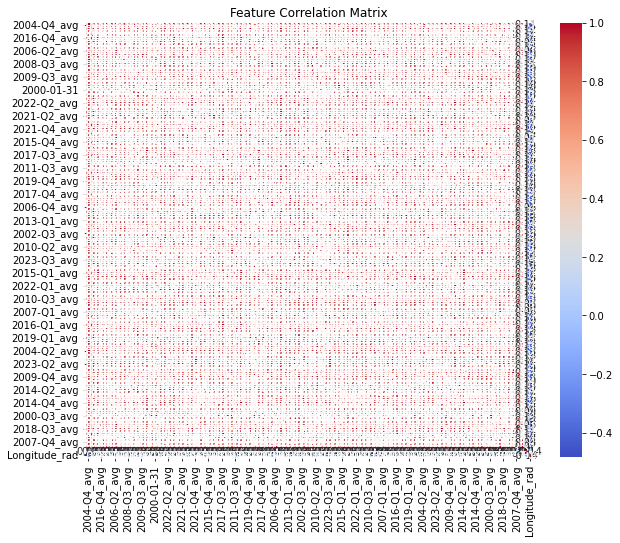

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


features = cols_to_normalize  + ['Latitude_rad']+['Longitude_rad']


corr_matrix = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np


df = pd.read_csv('normalized_clean_data.csv')


scaler = MinMaxScaler()


quarter_columns = [col for col in df.columns if 'Q' in col and 'avg' in col]

df[quarter_columns] = scaler.fit_transform(df[quarter_columns])


df_long = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'Latitude', 'Longitude'], 
                  var_name='Time', value_name='Value')


df_long['Year'] = df_long['Time'].str.split('-').str[0]
df_long['Quarter'] = df_long['Time'].str.split('-').str[1].str.replace('_avg', '')


df_wide = df_long.pivot_table(index=['RegionID', 'Year', 'Latitude', 'Longitude'],
                              columns='Quarter', values='Value').reset_index()


df_wide['Latitude_rad'] = np.radians(df_wide['Latitude'])
df_wide['Longitude_rad'] = np.radians(df_wide['Longitude'])


df_wide['Lat_Long_Metric'] = (np.sin(df_wide['Latitude_rad']) + np.cos(df_wide['Longitude_rad'])) / 2


df_wide.drop(['Latitude', 'Longitude', 'Latitude_rad', 'Longitude_rad'], axis=1, inplace=True)


df_wide.to_csv('new_df')


# Proposed Solution

In this section, clearly describe a solution to the problem. The solution should be applicable to the project domain and appropriate for the dataset(s) or input(s) given. Provide enough detail (e.g., algorithmic description and/or theoretical properties) to convince us that your solution is applicable. Make sure to describe how the solution will be tested.  

If you know details already, describe how (e.g., library used, function calls) you plan to implement the solution in a way that is reproducible.

If it is appropriate to the problem statement, describe a benchmark model<a name="sota"></a>[<sup>[3]</sup>](#sotanote) against which your solution will be compared. 

# Evaluation Metrics

Propose at least one evaluation metric that can be used to quantify the performance of both the benchmark model and the solution model. The evaluation metric(s) you propose should be appropriate given the context of the data, the problem statement, and the intended solution. Describe how the evaluation metric(s) are derived and provide an example of their mathematical representations (if applicable). Complex evaluation metrics should be clearly defined and quantifiable (can be expressed in mathematical or logical terms).

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
